In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2023-10-23 10:53:47,823	INFO worker.py:1636 -- Started a local Ray instance.


1.3624486320346218e-17 sr
	Flux for wavelength 8.130e-07 m: 3.998e+08 ph / (s m2)
	Flux for wavelength 8.250e-07 m: 3.840e+08 ph / (s m2)
	Flux for wavelength 8.370e-07 m: 3.691e+08 ph / (s m2)
Total flux: 1.153e+09 ph / (s m2)


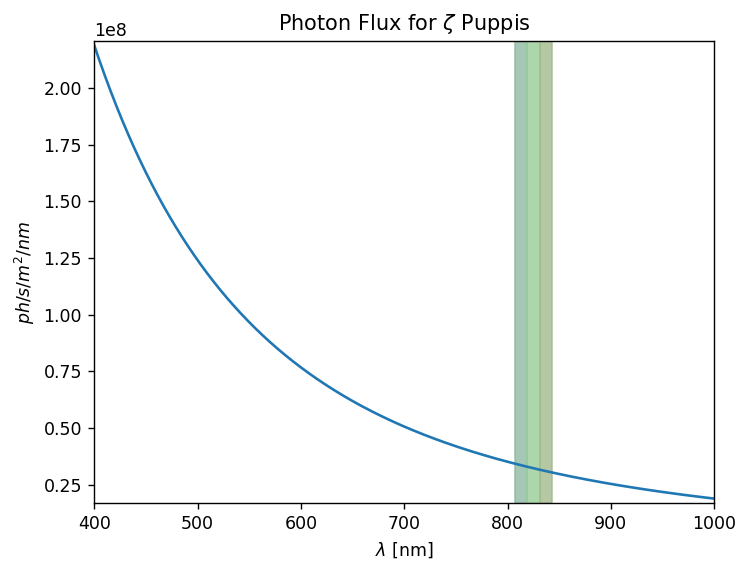

In [2]:
reload(cgi_phasec_poppy.source_flux)

wavelength_c = 825e-9*u.m

nwaves = 3
bandwidth = 2.9/100
minwave = wavelength_c * (1 - bandwidth/2)
maxwave = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minwave, maxwave, nwaves )

minlam = 400*u.nm
maxlam = 1000*u.nm
nlam = int((maxlam-minlam).value*20) + 1
lambdas = np.linspace(minlam, maxlam, nlam)

from astropy.constants import h, c, k_B, R_sun

zpup = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=40000*u.K,
                                            distance=300*u.parsec,
                                            diameter=2*14*R_sun,
                                            name='$\zeta$ Puppis', 
                                            lambdas=lambdas,
                                           )

zpup.plot_spectrum_ph()
source_fluxes = zpup.calc_fluxes()
total_flux = np.sum(source_fluxes)

for i,flux in enumerate(source_fluxes):
    print(f'\tFlux for wavelength {wavelengths[i]:.3e}: {flux:.3e}')
print(f'Total flux: {total_flux:.3e}')

In [3]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

kwargs = {
    'cgi_mode':'spc-wide',
    'npsf':150,
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':0,
}

actors = []
for i in range(nwaves):
    actors.append(rayCGI.options(num_cpus=2, num_gpus=1/8).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])
    actors[i].setattr.remote('source_flux', source_fluxes[i])

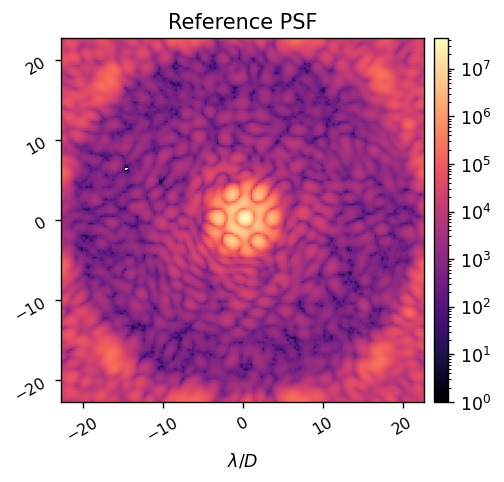

43691323.0


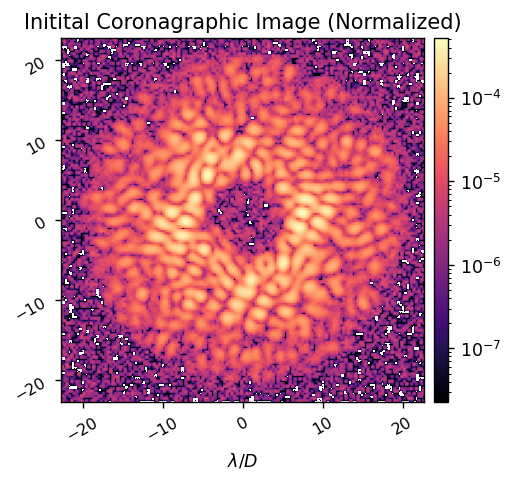

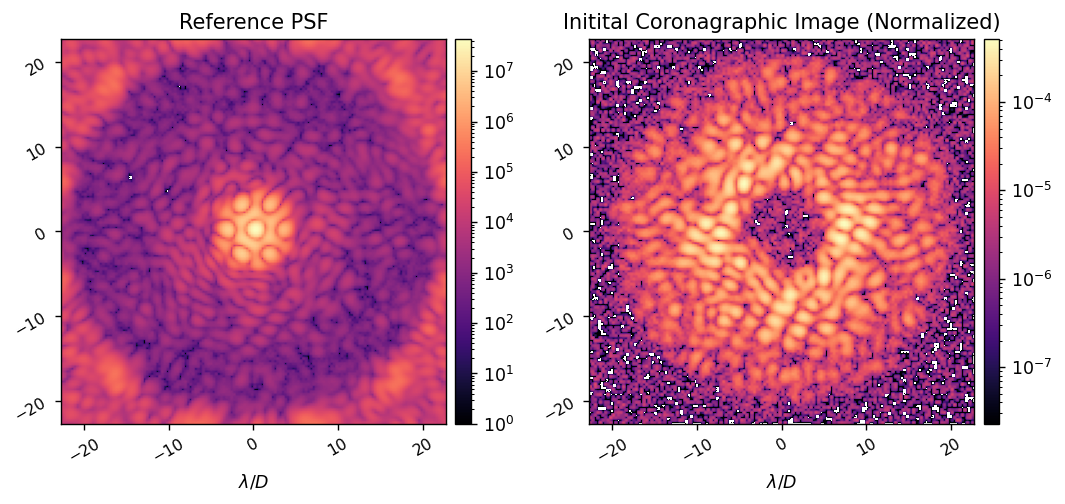

In [4]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)

mode.use_noise = True
mode.exp_time = 2*u.s
mode.gain = 1
mode.dark_current_rate = 0.05*u.electron/u.pix/u.hour
# mode.dark_current_rate = 0.0*u.electron/u.pix/u.hour
mode.read_noise = 120*u.electron/u.pix
# mode.read_noise = 0*u.electron/u.pix

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, 'Reference PSF',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = xp.max(ref_unocc_im)
print(max_ref)

mode.set_actor_attr('use_fpm',True)
mode.Imax_ref = max_ref
mode.exp_time_ref = mode.exp_time
mode.gain_ref = mode.gain

mode.exp_time = 2*u.s
mode.gain = 1

ref_im = mode.snap()
imshow1(ref_im, 'Initital Coronagraphic Image (Normalized)', 
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

imshow2(ref_unocc_im, ref_im, 'Reference PSF', 'Initital Coronagraphic Image (Normalized)', 
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, 
        # save_fig='test_bb_ims.png', 
        )

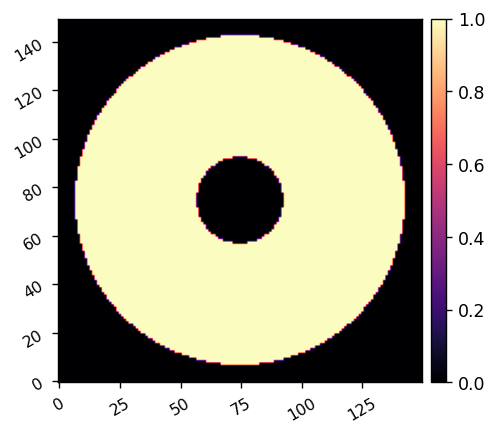

3.0542596879996946e-05


In [5]:
reload(utils)
control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)

mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

(4096, 4608)


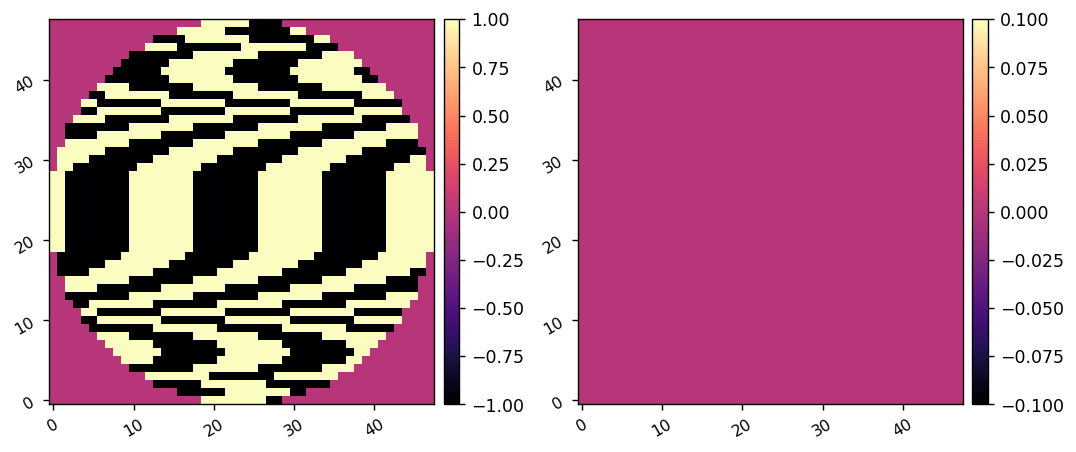

In [6]:
calib_amp = 10e-9
calib_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=2)
Nmodes = calib_modes.shape[0]
print(calib_modes.shape)
i = 8
imshow2(calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), calib_modes[i+mode.Nacts,mode.Nact**2:].reshape(mode.Nact,mode.Nact))


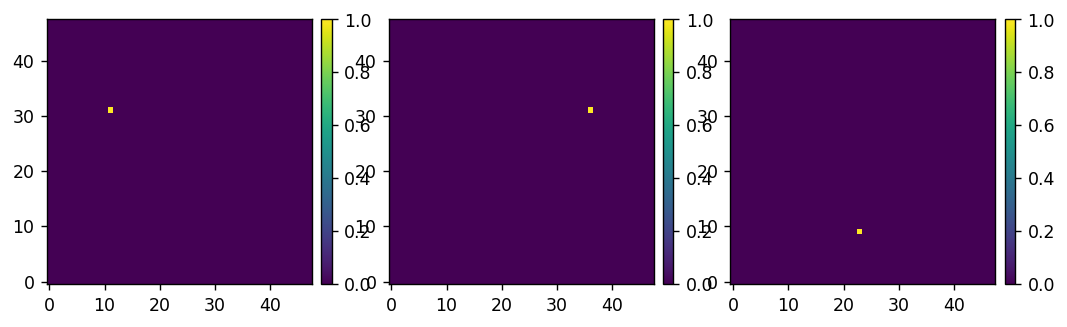

In [7]:
probe_amp = 2.5e-8
# probe_modes = utils.create_poke_probes([(10,34), (38,34), (24,10)], plot=True)
probe_modes = utils.create_poke_probes([(11,31), (36,31), (23,9)], plot=True)


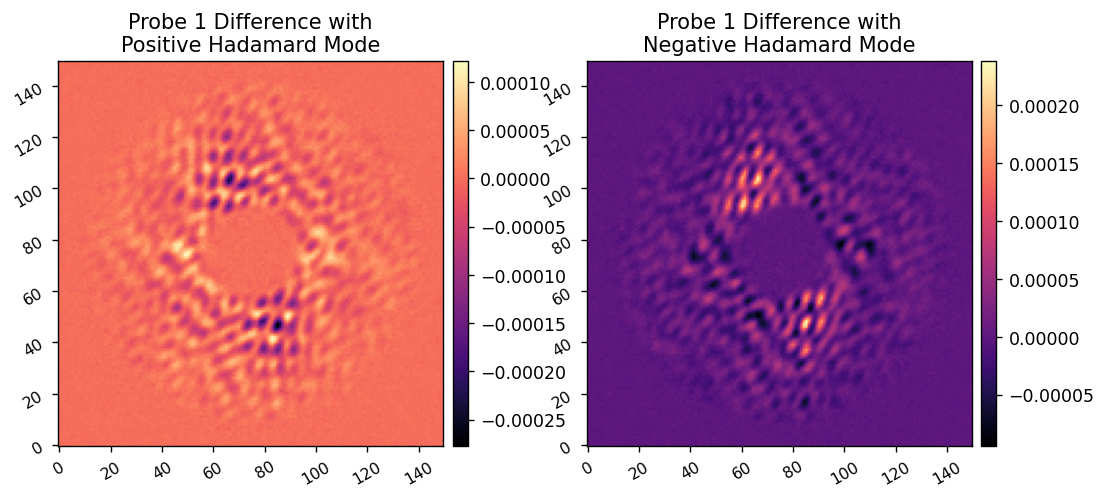

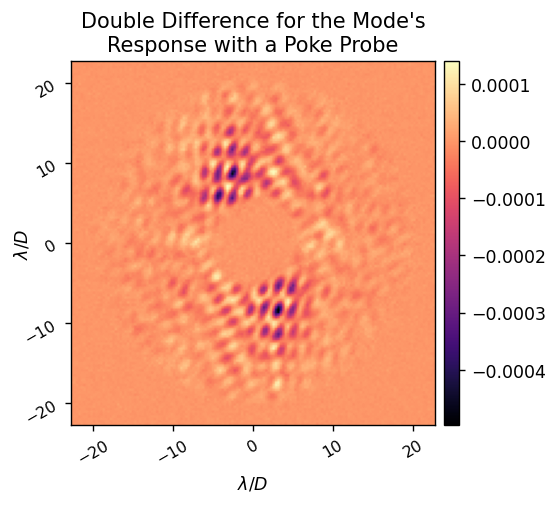

In [8]:
mode.exp_time = 2*u.s
mode.gain = 1

calib_amp = 10e-9

mode.add_dm1(calib_amp * calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))
mode.add_dm1(probe_amp * probe_modes[0])
im1 = mode.snap()
mode.add_dm1(-2*probe_amp * probe_modes[0])
im2 = mode.snap()
mode.add_dm1(probe_amp * probe_modes[0])

mode.add_dm1(-2*calib_amp * calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))
mode.add_dm1(probe_amp * probe_modes[0])
im3 = mode.snap()
mode.add_dm1(-2*probe_amp * probe_modes[0])
im4 = mode.snap()
mode.add_dm1(probe_amp * probe_modes[0])
mode.add_dm1(calib_amp * calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))

del1 = im1-im2
del2 = im3-im4

deldel = del1 - del2

imshow2(del1, del2, 
        'Probe 1 Difference with\nPositive Hadamard Mode',
        'Probe 1 Difference with\nNegative Hadamard Mode',)
fig,ax = imshow1(deldel, 'Double Difference for the Mode\'s\nResponse with a Poke Probe',
        pxscl=mode.psf_pixelscale_lamD,
        xlabel='$\lambda/D$',
        display_fig=False, return_fig=True,
        )
ax.set_ylabel('$\lambda/D$', labelpad=-5)
fig.savefig('dd_for_poke_probe.pdf', format='pdf', bbox_inches="tight")
display(fig)

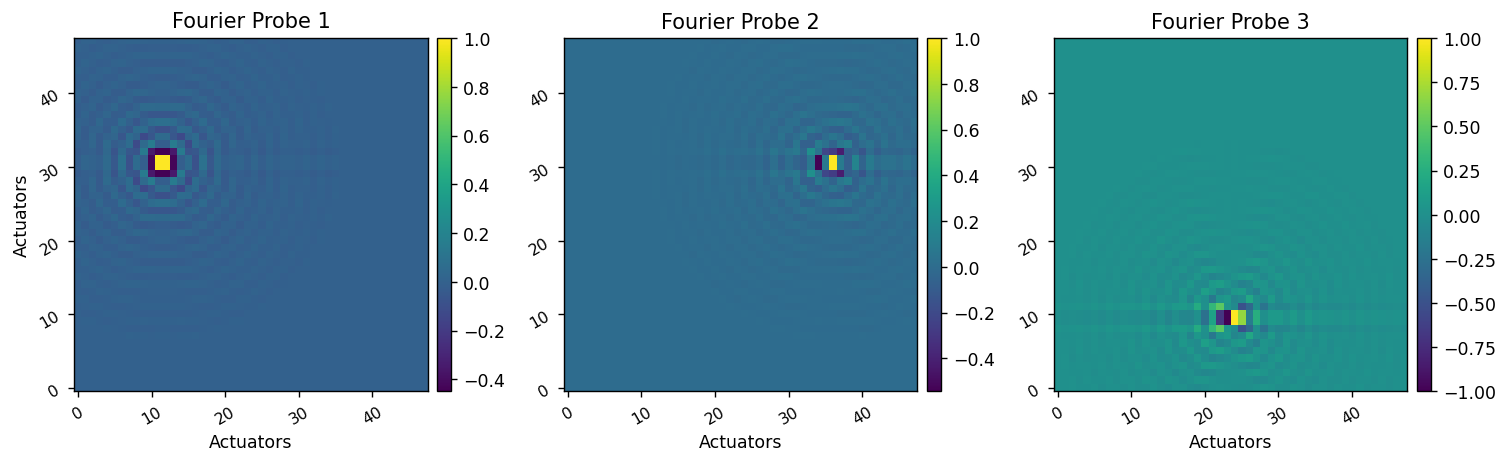

In [9]:
reload(utils)
probe_amp = 2.5e-8
probe_modes = utils.create_fourier_probes(mode, control_mask, fourier_sampling=0.2,
                                          shift=[(-12,7), (12,7),(0,-14), (0,0)], nprobes=3,
                                           use_weighting=True,
                                             plot=False)

fig,ax = imshow3(probe_modes[0], probe_modes[1], probe_modes[2], 
        'Fourier Probe 1', 'Fourier Probe 2', 'Fourier Probe 3', 
        cmap1='viridis', cmap2='viridis', cmap3='viridis',
        display_fig=False, return_fig=True
        )
ax[0].set_ylabel('Actuators')
ax[0].set_xlabel('Actuators')
ax[1].set_xlabel('Actuators')
ax[2].set_xlabel('Actuators')
fig.savefig('fourier_probes.pdf', format='pdf', bbox_inches="tight")
display(fig)

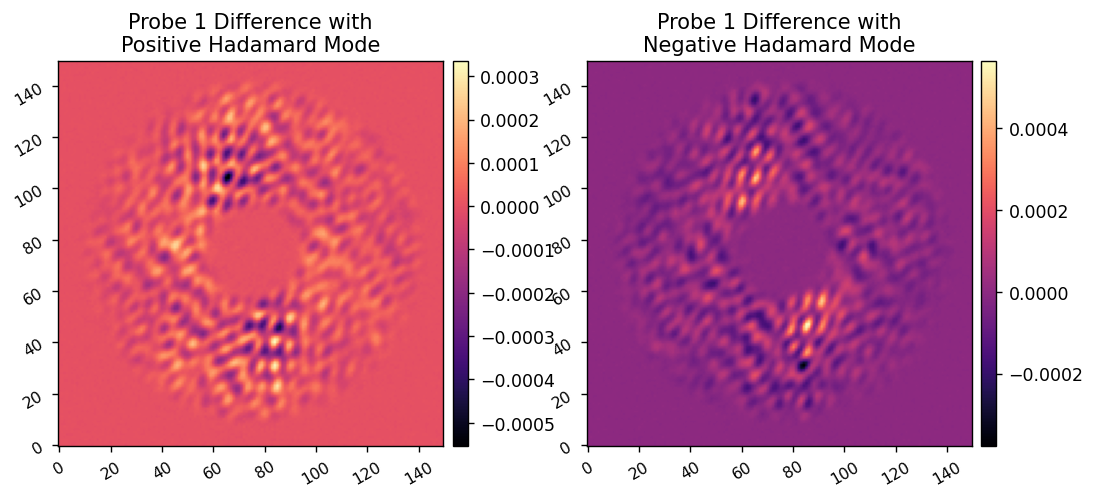

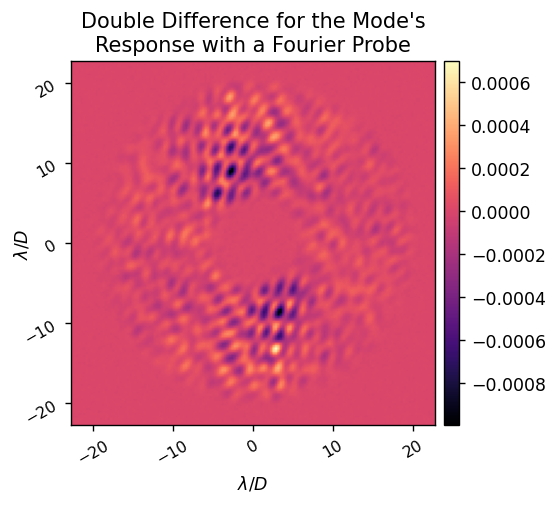

In [10]:
mode.exp_time = 2*u.s
mode.gain = 1

calib_amp = 10e-9

mode.add_dm1(calib_amp * calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))
mode.add_dm1(probe_amp * probe_modes[0])
im1 = mode.snap()
mode.add_dm1(-2*probe_amp * probe_modes[0])
im2 = mode.snap()
mode.add_dm1(probe_amp * probe_modes[0])

mode.add_dm1(-2*calib_amp * calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))
mode.add_dm1(probe_amp * probe_modes[0])
im3 = mode.snap()
mode.add_dm1(-2*probe_amp * probe_modes[0])
im4 = mode.snap()
mode.add_dm1(probe_amp * probe_modes[0])
mode.add_dm1(calib_amp * calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))

del1 = im1-im2
del2 = im3-im4

deldel = del1 - del2

imshow2(del1, del2, 
        'Probe 1 Difference with\nPositive Hadamard Mode',
        'Probe 1 Difference with\nNegative Hadamard Mode',)
fig,ax = imshow1(deldel, 'Double Difference for the Mode\'s\nResponse with a Fourier Probe',
        pxscl=mode.psf_pixelscale_lamD,
        xlabel='$\lambda/D$',
        display_fig=False, return_fig=True,
        )
ax.set_ylabel('$\lambda/D$', labelpad=-5)
fig.savefig('dd_for_fourier_probe.pdf', format='pdf', bbox_inches="tight")
display(fig)


In [19]:
date = 20231017
response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_band4b_had_modes_response_matrix_{date}.fits'))

5479315191210.504


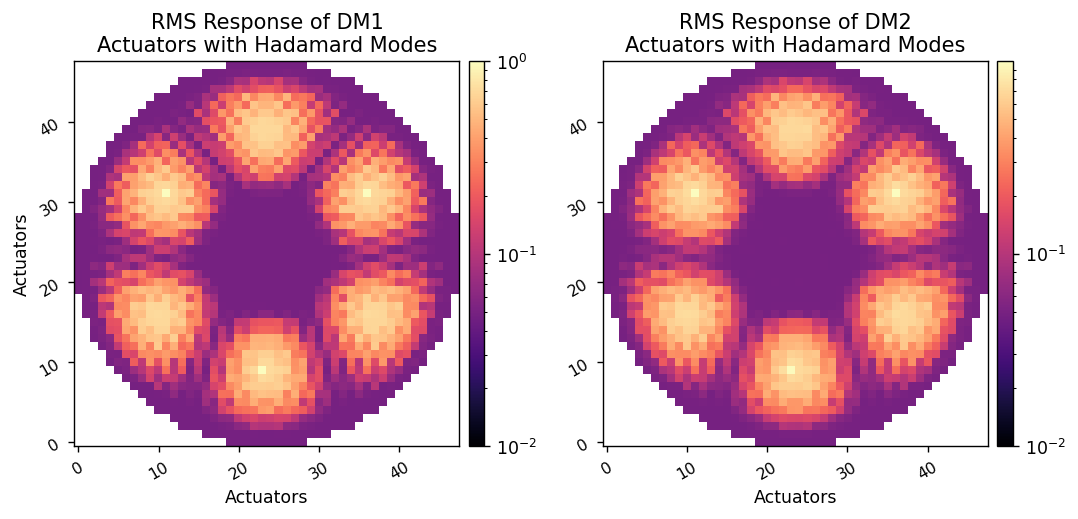

In [26]:
response_matrix.shape

dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm_response.max()
dm2_response = dm_response[mode.Nact**2:].reshape(mode.Nact, mode.Nact)/dm_response.max()

print(dm_response.max())
fig,ax = imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1\nActuators with Hadamard Modes', 'RMS Response of DM2\nActuators with Hadamard Modes',
        lognorm=True, vmax1=1, vmin1=0.01, vmin2=0.01,
        return_fig=True, display_fig=False,
        )
ax[0].set_ylabel('Actuators')
ax[0].set_xlabel('Actuators')
ax[1].set_xlabel('Actuators')
fig.savefig('had_modes_3pokes_responses.pdf', format='pdf', bbox_inches="tight")
display(fig)

4.4374578080478615e-08


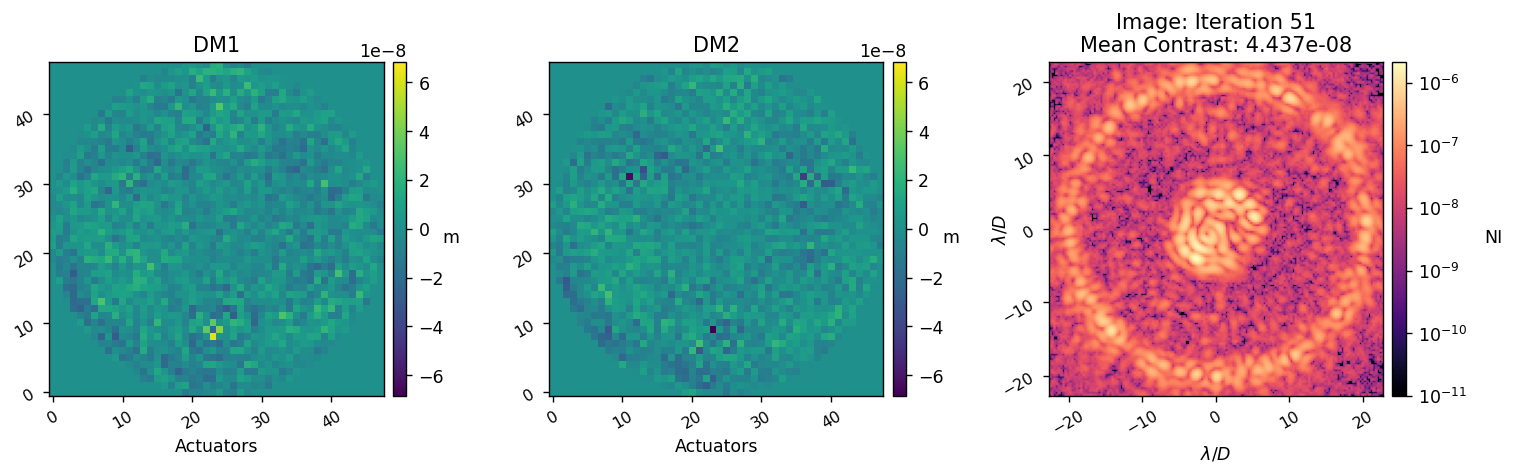

In [7]:
date = 20231017
dm1s = fits.getdata(response_dir/f'spc_wfov_band4b_had_dm1_commands_{date}.fits')
dm2s = fits.getdata(response_dir/f'spc_wfov_band4b_had_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_band4b_had_images_{date}.fits')

contrast = np.mean(ims[:,ensure_np_array(control_mask)], axis=1)
contrast.shape

i = np.argmin(contrast)
print(contrast[i])

dm_max = np.max(np.abs(np.concatenate([dm1s[i], dm2s[i]])))
dm1_rms = np.sqrt(np.mean(dm1s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm2_rms = np.sqrt(np.mean(dm2s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm1_p2v = (np.max(dm1s[i]) - np.min(dm1s[i]))*1e9
dm2_p2v = (np.max(dm2s[i]) - np.min(dm2s[i]))*1e9
fig, ax = imshow3(dm1s[i], dm2s[i], ims[i], 
        f'DM1', 
        f'DM2',
        f'Image: Iteration {i}\nMean Contrast: {contrast[i]:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='Actuators', xlabel2='Actuators', xlabel3='$\lambda/D$', 
        pxscl3=mode.psf_pixelscale_lamD,
        vmin1=-dm_max, vmax1=dm_max, vmin2=-dm_max, vmax2=dm_max, 
        symlognorm3=True, vmin3=1e-11,
        wspace=0.4,
        display_fig=False, return_fig=True)
ax[2].set_ylabel('$\lambda/D$', labelpad=-5)
fig.savefig('had_modes_3pokes.pdf', format='pdf', bbox_inches="tight")
display(fig)

1.4078738981102077e-08


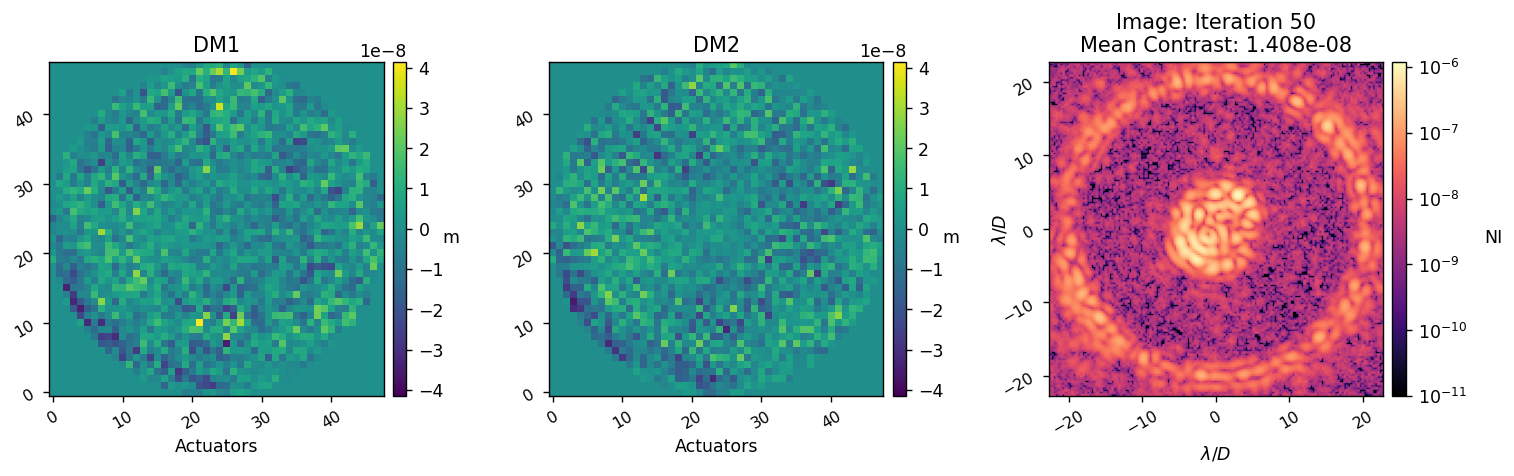

In [8]:
date = 20231018
dm1s = fits.getdata(response_dir/f'spc_wfov_band4b_had_fourier_dm1_commands_{date}.fits')
dm2s = fits.getdata(response_dir/f'spc_wfov_band4b_had_fourier_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_band4b_had_fourier_images_{date}.fits')

contrast = np.mean(ims[:,ensure_np_array(control_mask)], axis=1)
contrast.shape

i = np.argmin(contrast)
print(contrast[i])

dm_max = np.max(np.abs(np.concatenate([dm1s[i], dm2s[i]])))
dm1_rms = np.sqrt(np.mean(dm1s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm2_rms = np.sqrt(np.mean(dm2s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm1_p2v = (np.max(dm1s[i]) - np.min(dm1s[i]))*1e9
dm2_p2v = (np.max(dm2s[i]) - np.min(dm2s[i]))*1e9
fig, ax = imshow3(dm1s[i], dm2s[i], ims[i], 
        f'DM1', 
        f'DM2',
        f'Image: Iteration {i}\nMean Contrast: {contrast[i]:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='Actuators', xlabel2='Actuators', xlabel3='$\lambda/D$', 
        pxscl3=mode.psf_pixelscale_lamD,
        vmin1=-dm_max, vmax1=dm_max, vmin2=-dm_max, vmax2=dm_max, 
        symlognorm3=True, vmin3=1e-11,
        wspace=0.4,
        display_fig=False, return_fig=True)
ax[2].set_ylabel('$\lambda/D$', labelpad=-5)
fig.savefig('had_modes_3fourier.pdf', format='pdf', bbox_inches="tight")
display(fig)
